In [2]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_stochastic, SEIR_stochastic, plot_samples

# Loading and Saving Data

In [200]:
import jhu
import covidtracking
import states
import sys

def load_data():

    # world data
    world = jhu.load_world()
    world = world.loc[:,(slice(None), 'tot', slice(None))] # only country totals
    country_names = world.columns.unique(level=0)
    
    # Need country populations!
    pop = {
        'Italy': 60.48e6,
        'US': 3.27e8,
    }

    data = {country: world[country].tot for country in country_names}

    place_names = {country: country for country in country_names}
    place_names['US'] = 'United States'
    place_names = dict(place_names, **states.states)
    
    # US state data
    US = covidtracking.load_us()
    traits = states.uga_traits()

    state_pop = { k: traits.totalpop[k] for k in traits.index }
    state_data = { k: US[k] for k in US.columns.unique(level=0) }

    # combine them
    data = dict(data, **state_data)
    pop = dict(pop, **state_pop)
    
    return data, pop, place_names


def save_samples(place, 
                 prior_samples,
                 mcmc_samples, 
                 post_pred_samples):
    
    # Save samples
    filename = f'out/{place}_samples.npz'
    np.savez(filename, 
             prior_samples = prior_samples,
             mcmc_samples = mcmc_samples, 
             post_pred_samples = post_pred_samples)

    # Write diagnostics to file
    filename = f'out/{place}_summary.txt'
    orig_stdout = sys.stdout
    with open(filename, 'w') as f:
        sys.stdout = f
        mcmc.print_summary()

    sys.stdout = orig_stdout
    
def load_samples(place):
    
    filename = f'out/{place}_samples.npz'
    x = np.load(filename, allow_pickle=True)
    
    prior_samples = x['prior_samples'].item()
    mcmc_samples = x['mcmc_samples'].item()
    post_pred_samples = x['post_pred_samples'].item()
    
    return prior_samples, mcmc_samples, post_pred_samples

# Run Inference

In [ ]:
data, pop, place_names = load_data()

prob_models = {
    'SIR': SIR_stochastic,
    'SEIR': SEIR_stochastic
}

model = 'SEIR'

prob_model = prob_models[model]

#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['NY']
places = list(states.states.keys())

for place in places:

    print(f"******* {place} *********")
    
    start = pd.Timestamp('2020-03-04')
    confirmed = data[place].confirmed[start:]
    start = confirmed.index.min()

    T = len(confirmed)
    N = pop[place]

    args = {
        'N': N,
        'T': T,
        'drift_scale': 2e-1,
        'det_conc': 100,
    }

    print("NUTS")
    kernel = NUTS(prob_model,
                  init_strategy = numpyro.infer.util.init_to_median())

    print("MCMC")
    mcmc = MCMC(kernel, 
                num_warmup=1000, 
                num_samples=1000, 
                num_chains=1)

    print("run")
    mcmc.run(jax.random.PRNGKey(2), 
             obs = confirmed.values,
             **args)

    mcmc.print_summary()
    mcmc_samples = mcmc.get_samples()

    # Prior samples for comparison
    prior = Predictive(prob_model, posterior_samples = {}, num_samples = 1000)
    prior_samples = prior(PRNGKey(2), **args)
    
    # Posterior predictive samples for visualization
    args['drift_scale'] = 0 # set drift to zero for forecasting
    post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
    post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

    save_samples(place,
                 prior_samples,
                 mcmc_samples, 
                 post_pred_samples)

******* AK *********
NUTS
MCMC
run


sample: 100%|██████████| 2000/2000 [03:05<00:00, 10.76it/s, 255 steps of size 4.08e-03. acc. prob=0.88]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0      0.17      0.19      0.11      0.00      0.42     42.70      1.10
        I0      0.00      0.00      0.00      0.00      0.00    812.87      1.01
   beta[0]      5.47      2.96      4.81      1.36     10.02     40.45      1.11
   beta[1]      5.60      3.07      4.91      1.40      9.76     50.64      1.06
   beta[2]      5.51      3.14      4.68      1.44      9.88     65.93      1.04
   beta[3]      5.29      2.87      4.53      1.41      9.44     84.49      1.03
   beta[4]      4.92      2.69      4.40      1.32      8.73     98.06      1.02
   beta[5]      4.34      2.37      3.85      1.23      7.53    120.21      1.01
   beta[6]      3.75      1.89      3.34      1.19      6.38    169.94      1.00
   beta[7]      3.29      1.54      2.99      1.15      5.16    178.25      1.00
   beta[8]      3.03      1.40      2.75      1.03      4.74    130.59      1.01
   beta[9]      3.31      1

sample: 100%|██████████| 2000/2000 [05:25<00:00,  6.14it/s, 1023 steps of size 5.45e-05. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0      0.00      0.00      0.00      0.00      0.01      2.63      2.59
        I0      0.00      0.00      0.00      0.00      0.00      3.33      2.01
   beta[0]      7.59      0.07      7.59      7.49      7.72      5.97      1.34
   beta[1]     11.86      0.16     11.89     11.65     12.12      4.97      1.43
   beta[2]     16.01      0.56     16.05     15.11     16.81      2.58      2.44
   beta[3]     15.38      0.19     15.31     15.12     15.64      2.74      2.00
   beta[4]     20.99      0.39     20.90     20.48     21.64      3.60      1.50
   beta[5]     27.91      0.53     27.79     27.15     28.92      4.27      1.35
   beta[6]     49.10      1.32     49.25     46.74     51.12      5.61      1.18
   beta[7]     57.31      1.62     57.32     55.13     59.92      2.49      2.63
   beta[8]     55.36      0.91     55.17     54.00     56.88      4.06      1.41
   beta[9]     28.93      0

warmup:  12%|█▏        | 247/2000 [01:55<04:41,  6.23it/s, 1023 steps of size 3.80e-05. acc. prob=0.76] 

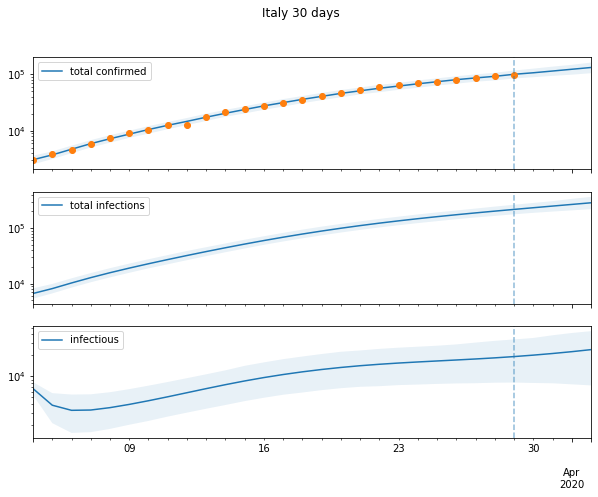

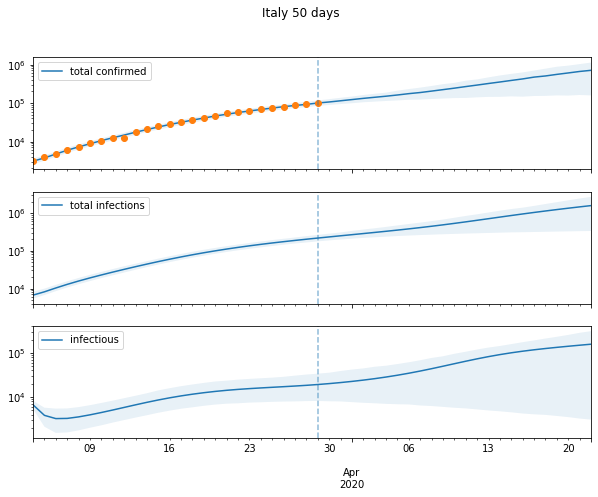

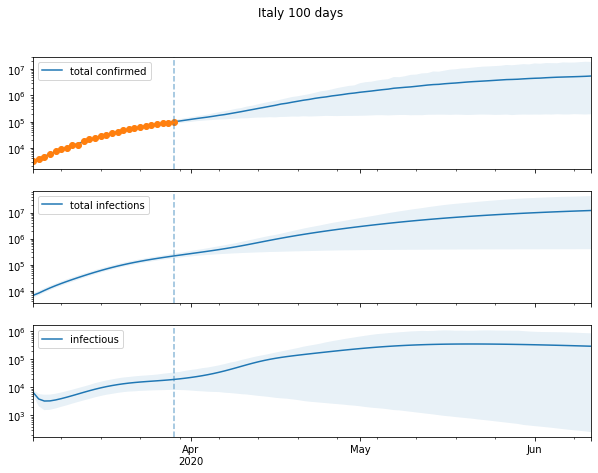

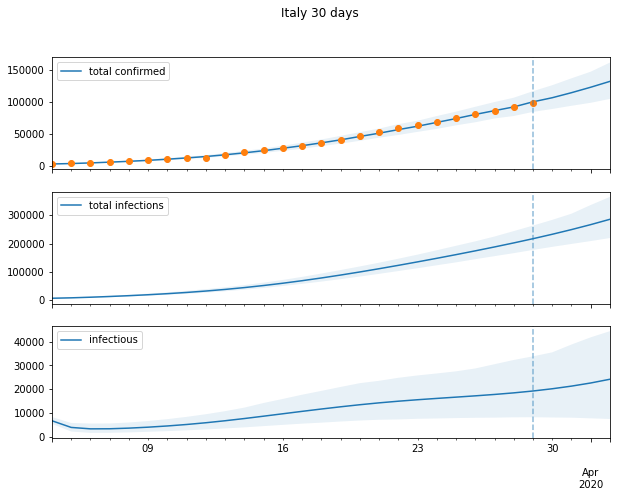

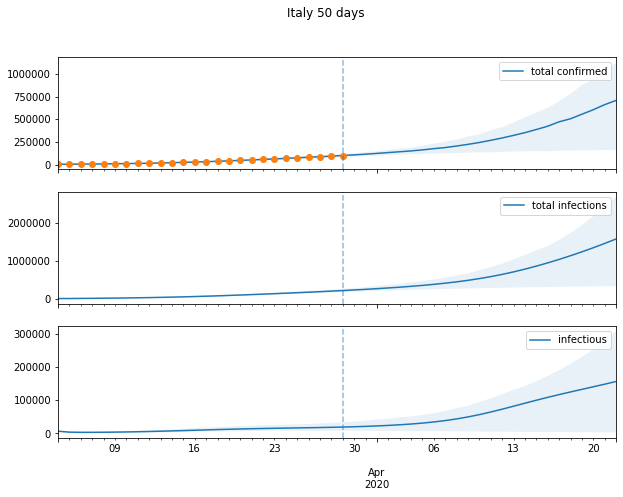

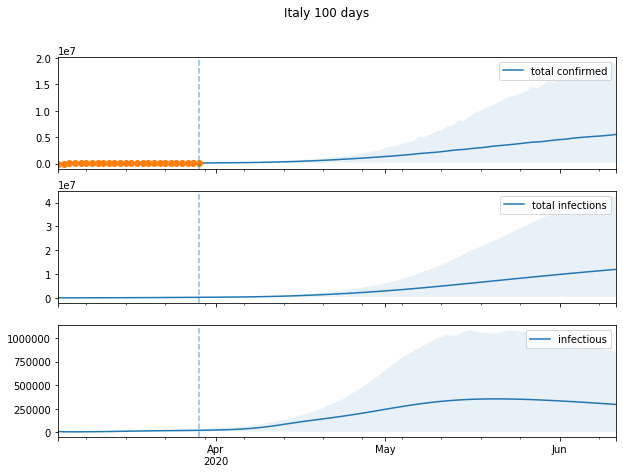

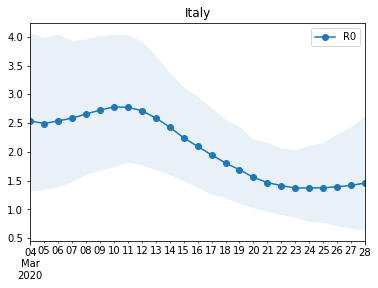

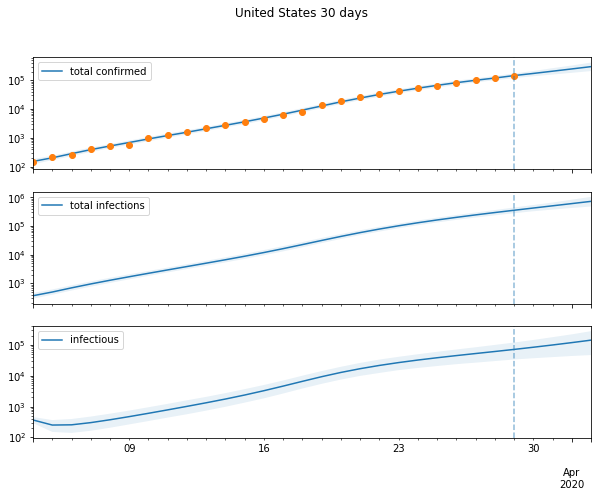

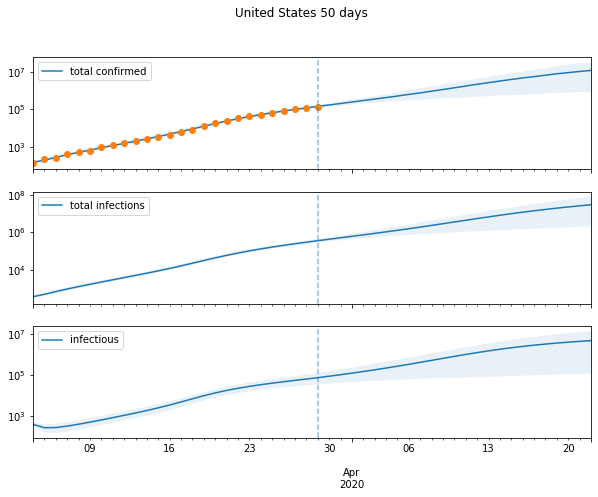

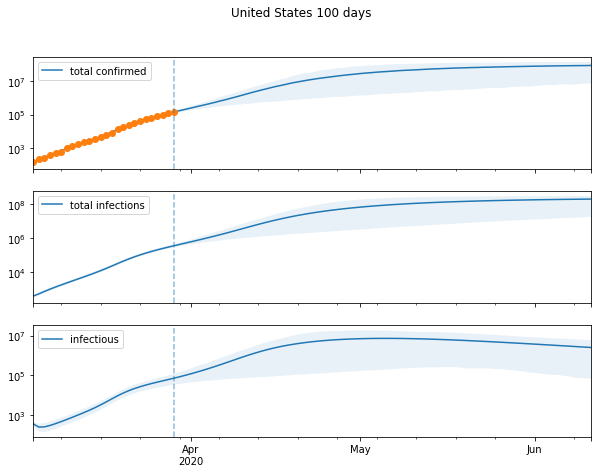

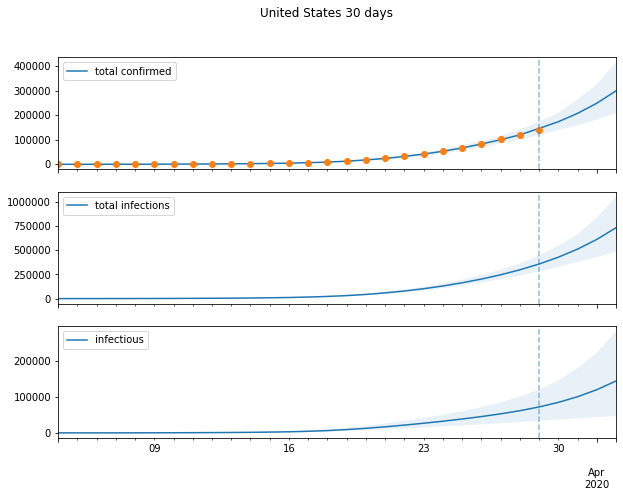

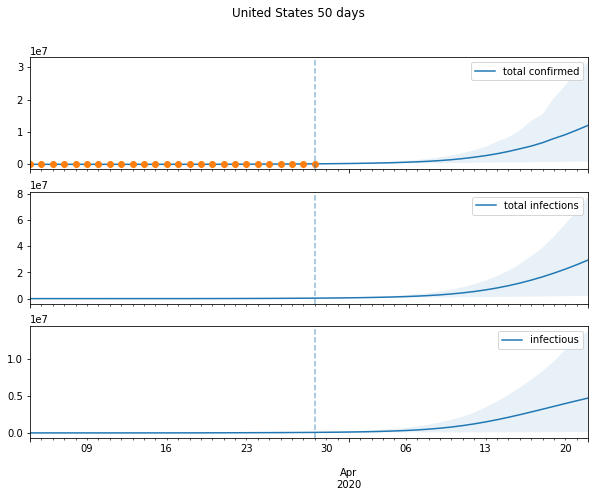

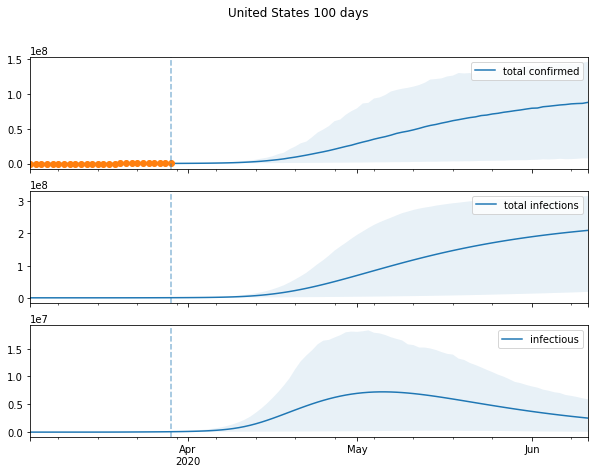

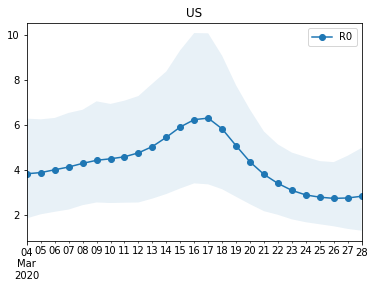

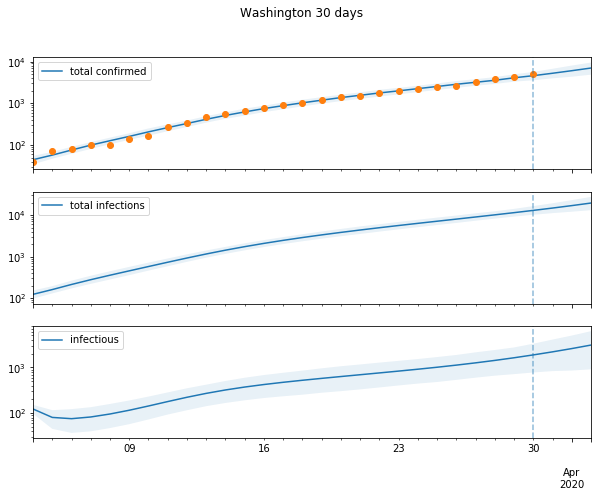

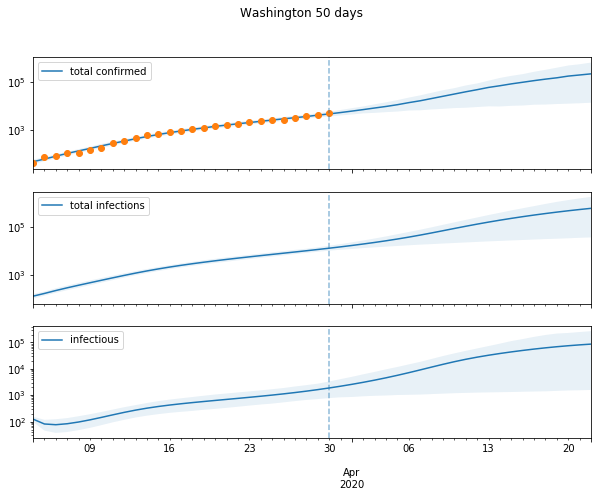

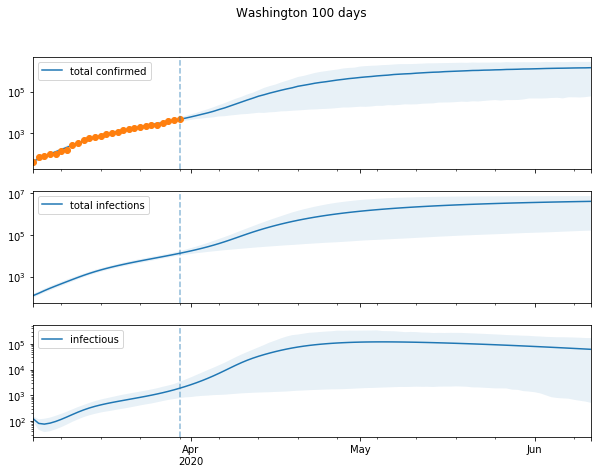

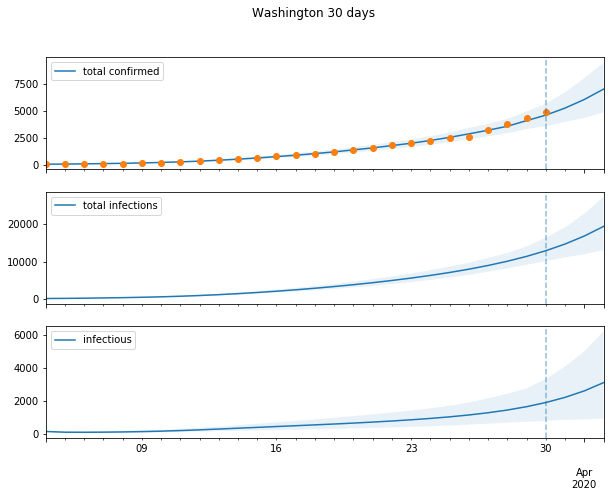

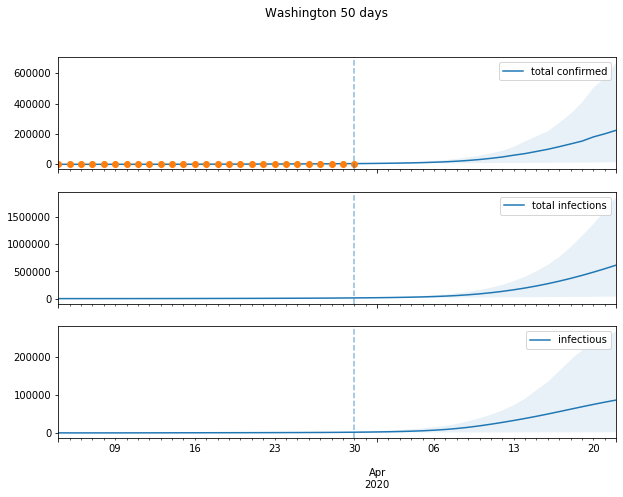

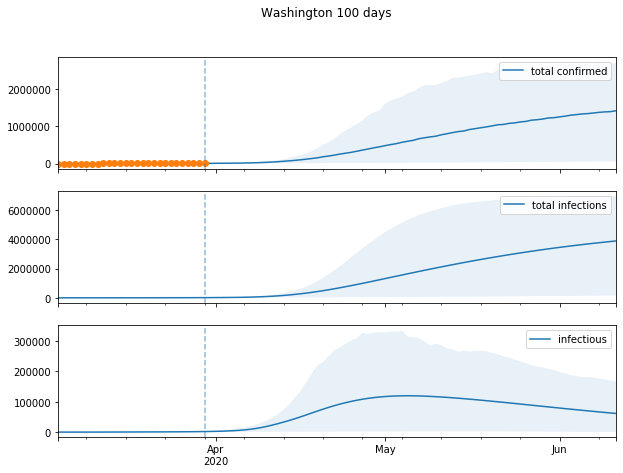

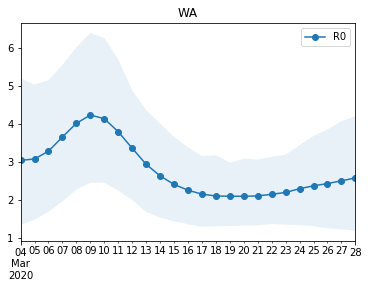

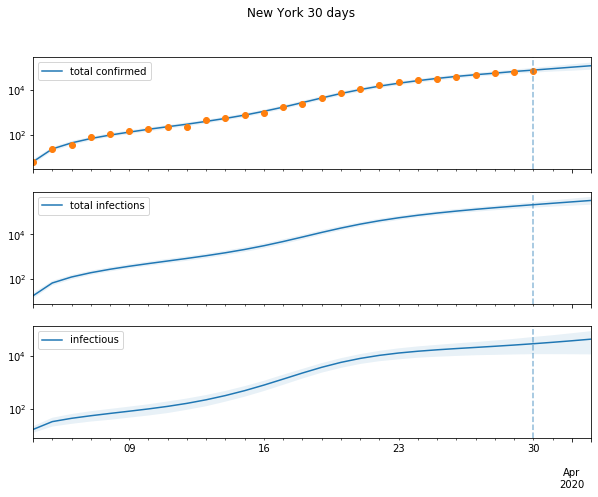

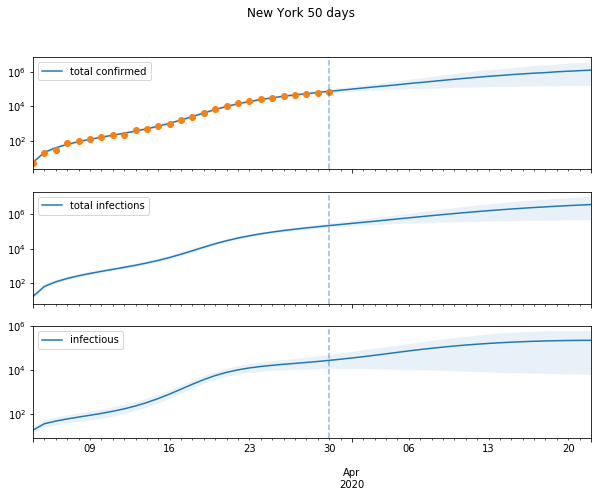

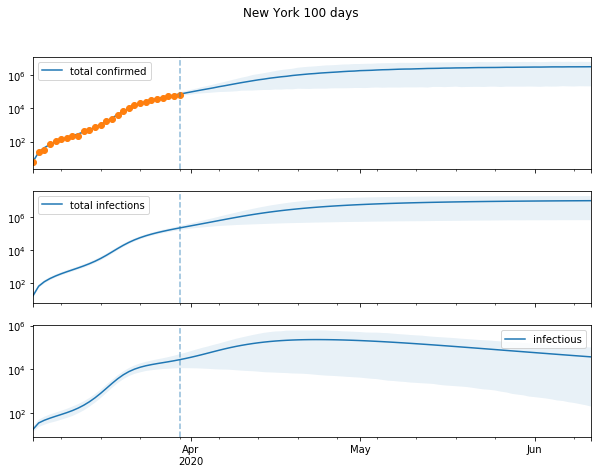

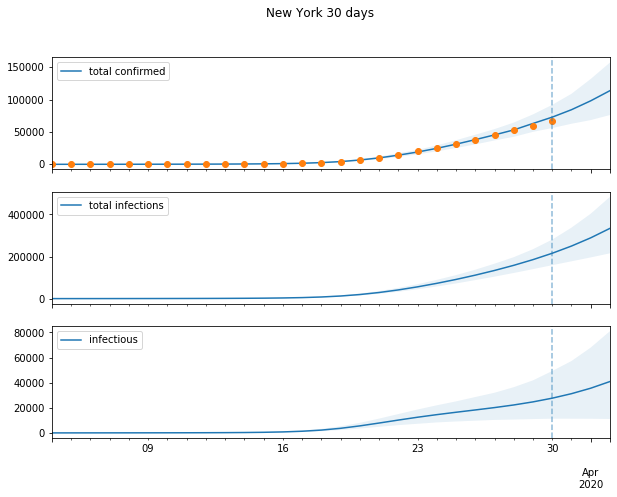

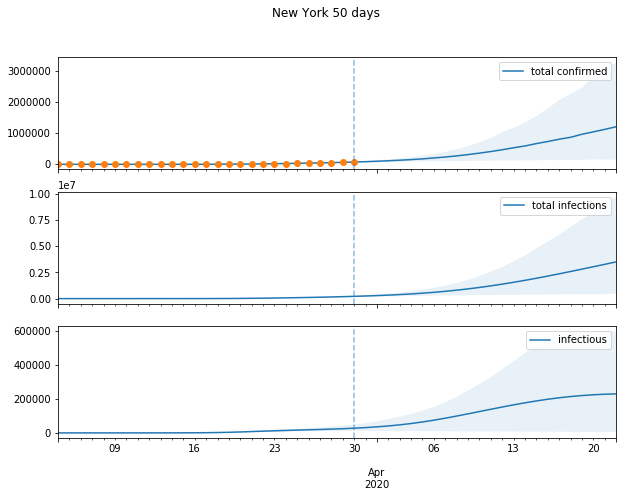

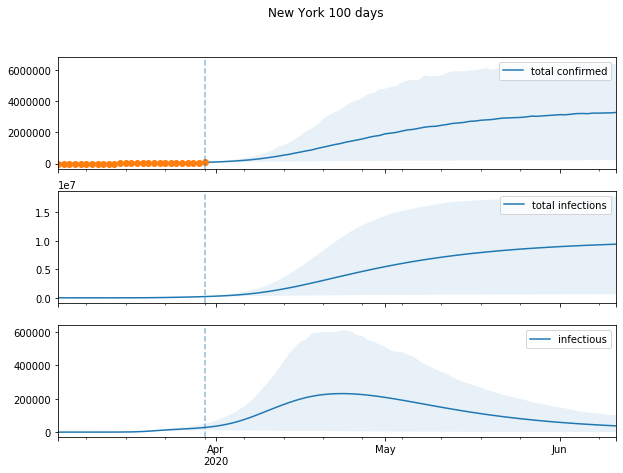

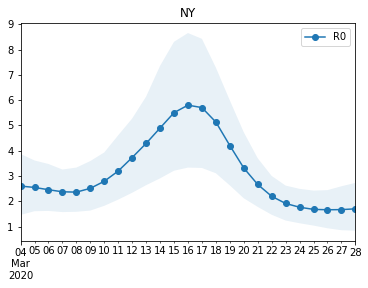

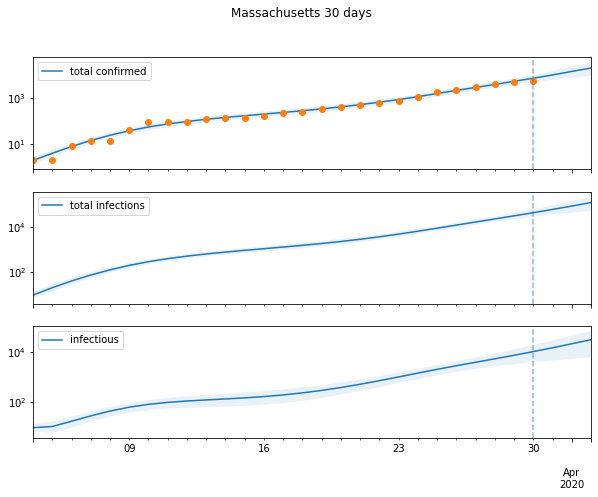

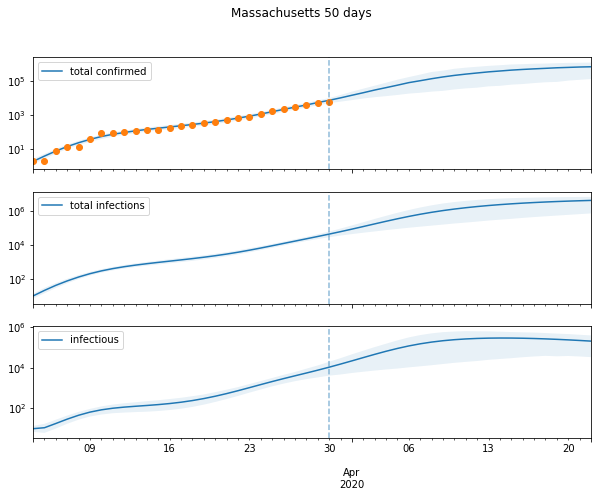

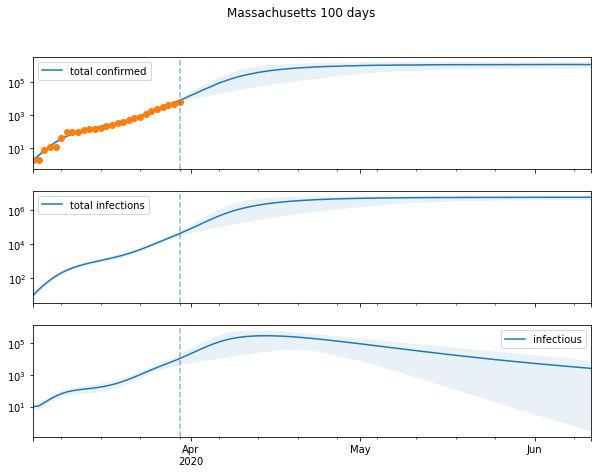

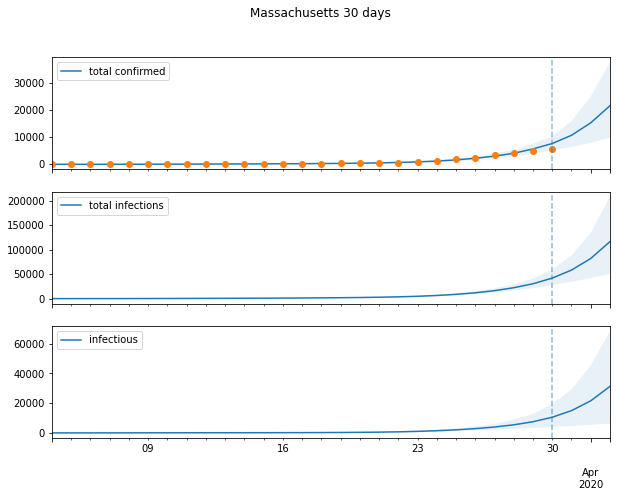

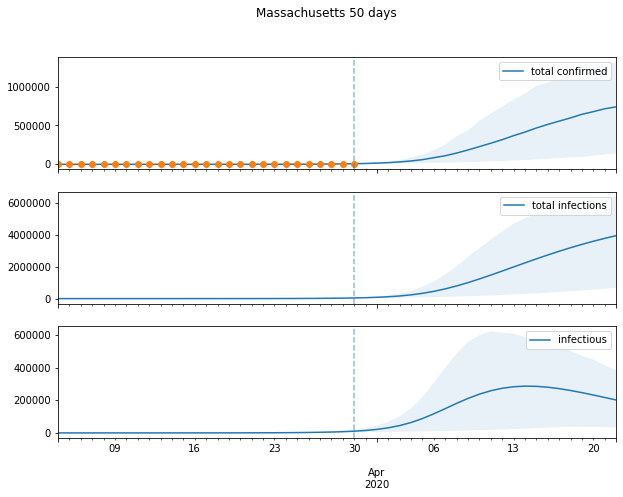

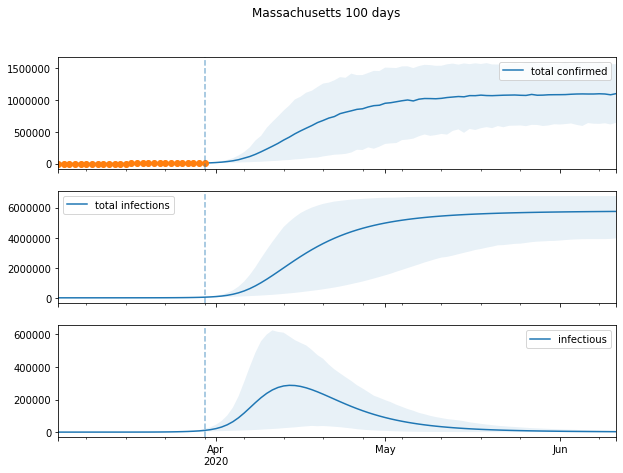

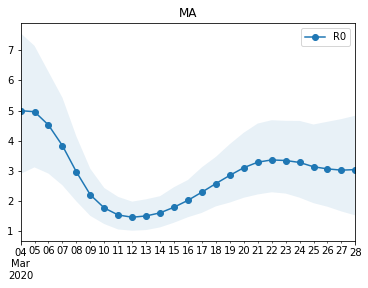

In [209]:
data, pop, place_names = load_data()

start = '2020-03-04'
places = ['Italy', 'US', 'WA', 'NY', 'MA']
##places = ['US']
##places = ['NY']

save = False

for place in places:
    
    confirmed = data[place].confirmed[start:]
    start_ = confirmed.index.min()

    T = len(confirmed)
    N = pop[place]

    prior_samples, mcmc_samples, post_pred_samples = load_samples(place)
    
    # Inspect and Save Results
    
    for scale in ['log', 'lin']:
        for T in [30, 50, 100]:

            t = pd.date_range(start=start_, periods=T, freq='D')
            
            fig, ax = plt.subplots(nrows=3, figsize=(10,7), sharex=True)

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[0], plot_fields=['y'], model=model)
            confirmed.plot(ax=ax[0], style='o')

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[1], plot_fields=['C'], model=model)

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[2], plot_fields=['I'], model=model)

            [a.axvline(confirmed.index.max(), linestyle='--', alpha=0.5) for a in ax]

            plt.suptitle(f'{place_names[place]} {T} days ')
            
            if scale == 'log':
                [a.set_yscale('log') for a in ax]
                
            if save:
                filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.png'
                plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start_, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': R0.mean(axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    if save:
        filename = f'figs/{place}_R0.png'
        plt.savefig(filename)

    plt.title(place)
    plt.show()

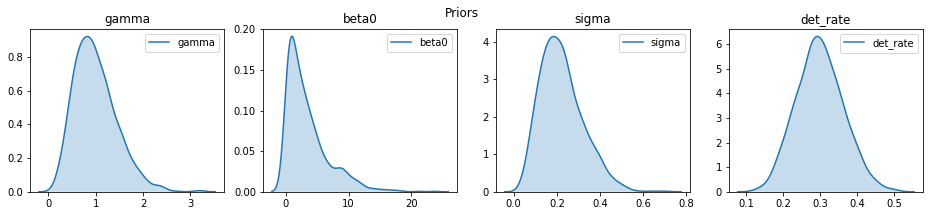

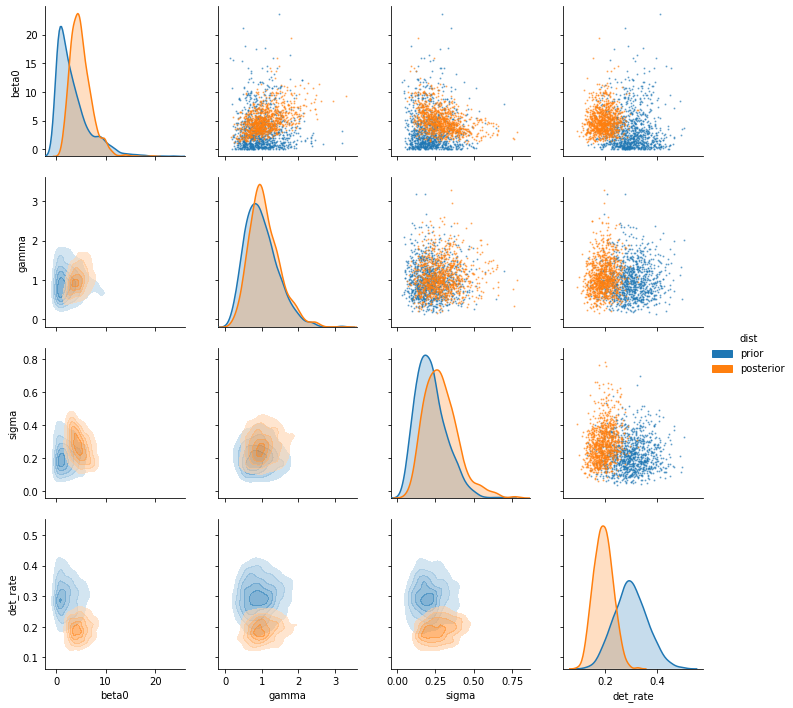

In [218]:
import seaborn as sns

cols = ['gamma', 'beta0', 'sigma', 'det_rate']

def get_cols(d):
    return {k: v for k, v in d.items() if k in cols}

prior_df = pd.DataFrame(get_cols(prior_samples))
posterior_df = pd.DataFrame(get_cols(mcmc_samples))

prior_df['dist'] = 'prior'
posterior_df['dist'] = 'posterior'

# Visualize priors
fig, ax = plt.subplots(ncols=len(cols), figsize=(16,3))
for i in range(len(cols)):
    sns.kdeplot(prior_df[cols[i]], ax=ax[i], shade=True)
    ax[i].set_title(cols[i])
    plt.suptitle('Priors')
plt.show()
    
# Compare posterior to prior
df = pd.concat([prior_df, posterior_df])
g = sns.PairGrid(df, hue='dist', diag_sharey=False, vars=['beta0', 'gamma', 'sigma', 'det_rate'])
g = g.map_diag(sns.kdeplot, shade=True)
g = g.map_upper(plt.scatter, s=1, alpha=0.5)
g = g.map_lower(sns.kdeplot, n_levels=5, shade=True, shade_lowest=False, alpha=0.6)
g = g.add_legend()
plt.show()

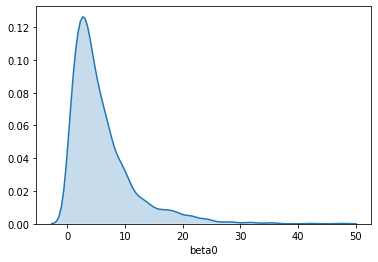

In [61]:
sns.distplot(df['beta0'], hist=False, kde_kws={'shade': True})

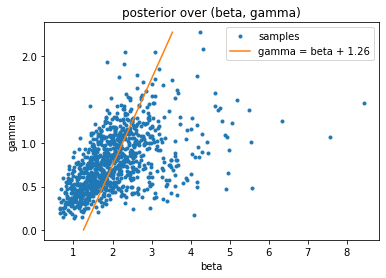

R0: 2.9294224


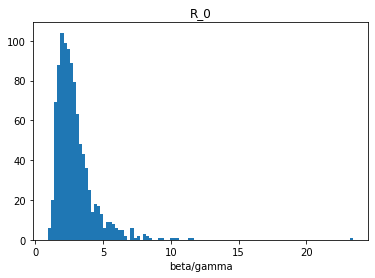

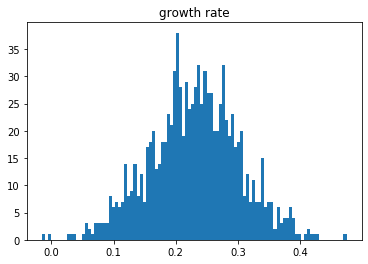

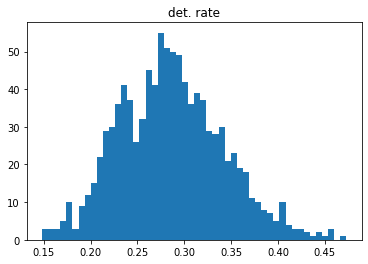

In [44]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

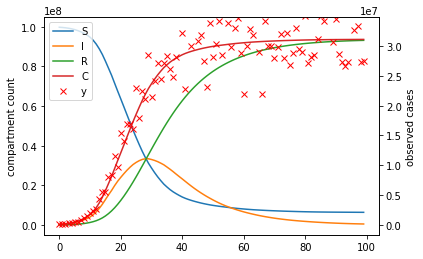

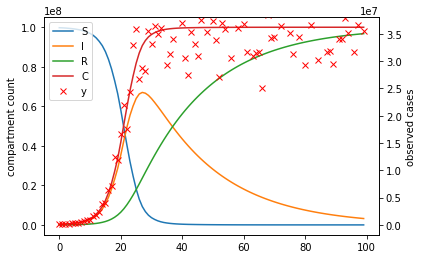

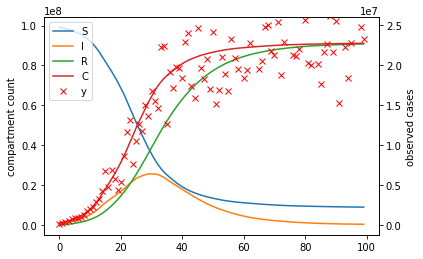

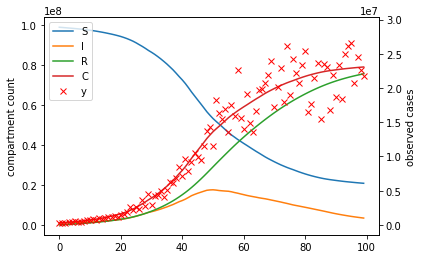

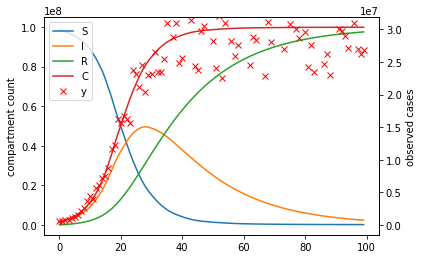

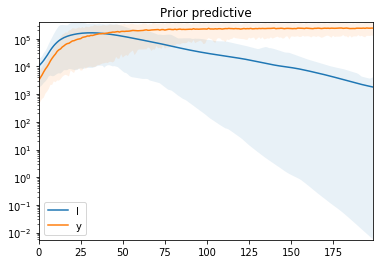

In [147]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, obs_rate = SIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)    
    l2 = ax2.plot(ts, y, 'x', color='r')
        
    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=50, T_future=50, N=1e8)
        
    test_prior_predictive()

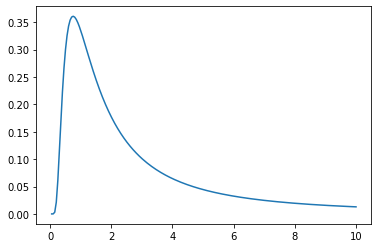

In [11]:
d = dist.Gamma(1, 1 * 1.5)
e = dist.TransformedDistribution(d, dist.transforms.PowerTransform(-1))
x = np.linspace(0, 10, 200)
plt.plot(x, np.exp(e.log_prob(x)))



In [42]:
mcmc_samples = None

place = 'WA'
filename = f'out/{place}_samples.npz'
x = np.load(filename, allow_pickle=True)
#print(x['arr_0']['E0'])
mcmc_samples = x['arr_0'].item()
post_pred_samples = x['arr_0'].item()

mcmc_samples['E0']

array([8.66874619e+01, 4.15219696e+02, 4.45294373e+02, 2.56993042e+02,
       7.04531937e+01, 1.18157928e+02, 1.36333282e+02, 1.07267029e+02,
       8.06847839e+01, 8.15182419e+01, 8.50297852e+01, 1.01856270e+02,
       1.20759430e+02, 1.11948647e+02, 1.02471603e+02, 8.55147476e+01,
       4.72280006e+01, 2.64801849e+02, 4.25228485e+02, 1.49566147e+02,
       7.14774170e+01, 2.46033691e+02, 1.93305496e+02, 1.57670837e+02,
       1.99327652e+02, 3.03032928e+02, 1.67519287e+02, 3.97491730e+02,
       1.51864357e+01, 7.93717117e+01, 1.51606049e+02, 1.44905502e+02,
       2.77630524e+02, 8.47063522e+01, 4.99812088e+01, 5.57977142e+01,
       7.15447006e+01, 2.27100334e+01, 4.41022491e+01, 1.07956108e+02,
       5.55965576e+02, 2.58322235e+02, 4.25230896e+02, 1.67635040e+02,
       1.59257479e+01, 5.08653526e+01, 4.43552132e+01, 7.02877808e+01,
       7.97777634e+01, 9.82648163e+01, 2.54315414e+01, 1.59228363e+02,
       1.51452240e+02, 6.13588982e+01, 1.80332428e+02, 8.58205719e+01,
      

200.0 80000.0
[4.25021790e+02 7.99313498e+00 1.22378654e+01 9.78525085e+01
 2.95625782e+01 9.21434937e+01 1.99659562e+00 1.46415405e+02
 2.17686882e+01 5.70890747e+02 1.21237612e+01 6.88032837e+02
 5.20163774e+00 1.11034363e+02 1.08496065e+01 4.18368530e+02
 9.29497833e+01 5.98488708e+02 7.85658951e+01 4.72406447e-01
 1.25134659e+02 7.56160095e+02 2.40993500e+01 2.29274845e+00
 1.37548947e+00 9.53231335e+00 5.48246948e+02 3.18149292e+02
 5.18949341e+02 2.67432037e+02 1.33998032e+02 2.90978851e+02
 3.62943339e+00 5.25657475e-01 5.30890869e+02 7.27805402e-03
 4.49184265e+01 2.76976959e+02 7.11040268e+01 3.41208905e-01
 3.67720038e-01 7.24586548e+02 1.72992483e-01 2.42360725e+01
 1.66778015e+03 1.68412888e+00 1.35417572e+02 1.05265526e+02
 2.00509430e+02 5.71593933e+02 1.92386307e+02 2.21259033e+02
 5.75630493e+01 1.28455399e+02 3.95694946e+02 1.18873364e+03
 4.23314728e+02 4.03931999e+01 4.29233322e+01 5.31381378e+01
 2.94503727e+01 8.65386230e+02 1.67414413e+02 9.34550323e+01
 6.4712982

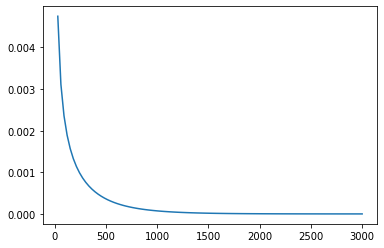

In [108]:
shape = 0.5
d = dist.Gamma(shape, shape/200)
x = np.linspace(0, 3000, 100)
plt.plot(x, np.exp(d.log_prob(x)))
print(d.mean, d.variance)

with numpyro.handlers.seed(rng_seed=1):
    x = numpyro.sample("x", d, sample_shape=(1000,))
    
print(x)

In [189]:
world = jhu.load_world()
countries = world.loc[:,(slice(None), 'tot', 'confirmed')]

,confirmed
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
...,...
2020-03-25,65778
2020-03-26,83836
2020-03-27,101657
2020-03-28,121478


In [201]:
data, pop, place_names = load_data()
place_names

{'Afghanistan': 'Afghanistan',
 'Albania': 'Albania',
 'Algeria': 'Algeria',
 'Andorra': 'Andorra',
 'Angola': 'Angola',
 'Antigua and Barbuda': 'Antigua and Barbuda',
 'Argentina': 'Argentina',
 'Armenia': 'Armenia',
 'Austria': 'Austria',
 'Azerbaijan': 'Azerbaijan',
 'Bahamas': 'Bahamas',
 'Bahrain': 'Bahrain',
 'Bangladesh': 'Bangladesh',
 'Barbados': 'Barbados',
 'Belarus': 'Belarus',
 'Belgium': 'Belgium',
 'Belize': 'Belize',
 'Benin': 'Benin',
 'Bhutan': 'Bhutan',
 'Bolivia': 'Bolivia',
 'Bosnia and Herzegovina': 'Bosnia and Herzegovina',
 'Brazil': 'Brazil',
 'Brunei': 'Brunei',
 'Bulgaria': 'Bulgaria',
 'Burkina Faso': 'Burkina Faso',
 'Burma': 'Burma',
 'Cabo Verde': 'Cabo Verde',
 'Cambodia': 'Cambodia',
 'Cameroon': 'Cameroon',
 'Central African Republic': 'Central African Republic',
 'Chad': 'Chad',
 'Chile': 'Chile',
 'Colombia': 'Colombia',
 'Congo (Brazzaville)': 'Congo (Brazzaville)',
 'Congo (Kinshasa)': 'Congo (Kinshasa)',
 'Costa Rica': 'Costa Rica',
 "Cote d'Ivoir